The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==version


# Numerical Stability and Initialization
:label:`sec_numerical_stability`


Thus far, every model that we have implemented
required that we initialize its parameters
according to some pre-specified distribution.
Until now, we took the initialization scheme for granted,
glossing over the details of how these these choices are made.
You might have even gotten the impression that these choices
are not especially important.
To the contrary, the choice of initialization scheme
plays a significant role in neural network learning,
and it can be crucial for maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the nonlinear activation function.
Which function we choose and how we initialize parameters
can determine how quickly our optimization algorithm converges.
Poor choices here can cause us to encounter
exploding or vanishing gradients while training.
In this section, we delve into these topics with greater detail
and discuss some useful heuristics
that you will find useful
throughout your career in deep learning.


## Vanishing and Exploding Gradients

Consider a deep network with $L$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
With each layer $l$ defined by a transformation $f_l$
parameterized by weights $\mathbf{W}_l$
our network can be expressed as:

$$\mathbf{h}^{l+1} = f_l (\mathbf{h}^l) \text{ and thus } \mathbf{o} = f_L \circ \ldots, \circ f_1(\mathbf{x}).$$

If all activations and inputs are vectors,
we can write the gradient of $\mathbf{o}$ with respect to
any set of parameters $\mathbf{W}_l$ as follows:

$$\partial_{\mathbf{W}_l} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{L-1}} \mathbf{h}^L}_{:= \mathbf{M}_L} \cdot \ldots, \cdot \underbrace{\partial_{\mathbf{h}^{l}} \mathbf{h}^{l+1}}_{:= \mathbf{M}_l} \underbrace{\partial_{\mathbf{W}_l} \mathbf{h}^l}_{:= \mathbf{v}_l}.$$

In other words, this gradient is
the product of $L-l$ matrices
$\mathbf{M}_L \cdot \ldots, \cdot \mathbf{M}_l$
and the gradient vector $\mathbf{v}_l$.
Thus we are susceptible to the same
problems of numerical underflow that often crop up
when multiplying together too many probabilities.
When dealing with probabilities, a common trick is to
switch into log-space, i.e., shifting
pressure from the mantissa to the exponent
of the numerical representation.
Unfortunately, our problem above is more serious:
initially the matrices $M_l$ may have a wide variety of eigenvalues.
They might be small or large, and
their product might be *very large* or *very small*.

The risks posed by unstable gradients
go beyond numerical representation.
Gradients of unpredictable magnitude
also threaten the stability of our optimization algorithms.
We may be facing parameter updates that are either
(i) excessively large, destroying our model
(the *exploding* gradient problem);
or (ii) excessively small
(the *vanishing gradient problem*),
rendering learning impossible as parameters
hardly move on each update.


### Vanishing Gradients

One frequent culprit causing the vanishing gradient problem
is the choice of the activation function $\sigma$
that is appended following each layer's linear operations.
Historically, the sigmoid function
$1/(1 + \exp(-x))$ (introduced in :numref:`sec_mlp`)
was popular because it resembles a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that fire either *fully* or *not at all*
(like biological neurons) seemed appealing.
Let us take a closer look at the sigmoid
to see why it can cause vanishing gradients.


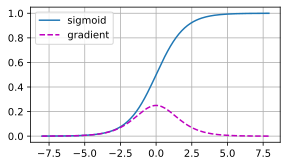

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

As you can see, the sigmoid's gradient vanishes
both when its inputs are large and when they are small.
Moreover, when backpropagating through many layers,
unless we are in the Goldilocks zone, where
the inputs to many of the sigmoids are close to zero,
the gradients of the overall product may vanish.
When our network boasts many layers,
unless we are careful, the gradient
will likely be cut off at *some* layer.
Indeed, this problem used to plague deep network training.
Consequently, ReLUs, which are more stable
(but less neurally plausible),
have emerged as the default choice for practitioners.


### Exploding Gradients

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw $100$ Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
When this happens due to the initialization
of a deep network, we have no chance of getting
a gradient descent optimizer to converge.


In [2]:
M = torch.normal(0, 1, size=(4,4))
print('A single matrix \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4,4)))

print('After multiplying 100 matrices\n',M)

A single matrix 
 tensor([[ 0.3021,  0.8541, -0.0111, -1.7852],
        [ 1.3675,  0.5243,  0.0085,  0.7796],
        [-0.8776,  0.2312,  2.7465,  0.2879],
        [ 1.2510, -0.5377, -0.1983, -0.1201]])
After multiplying 100 matrices
 tensor([[-9.0353e+25,  5.7558e+25, -8.6537e+25,  1.5004e+25],
        [-1.1864e+26,  7.5576e+25, -1.1363e+26,  1.9701e+25],
        [ 8.8911e+25, -5.6639e+25,  8.5157e+25, -1.4764e+25],
        [ 1.4998e+25, -9.5542e+24,  1.4365e+25, -2.4905e+24]])


### Symmetry

Another problem in deep network design
is the symmetry inherent in their parametrization.
Assume that we have a deep network
with one hidden layer and two units, say $h_1$ and $h_2$.
In this case, we could permute the weights $\mathbf{W}_1$
of the first layer and likewise permute
the weights of the output layer
to obtain the same function.
There is nothing special differentiating
the first hidden unit vs the second hidden unit.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Imagine what would happen if we initialized
all of the parameters of some layer
as $\mathbf{W}_l = c$ for some constant $c$.
In this case, the gradients
for all dimensions are identical:
thus not only would each unit take the same value,
but it would receive the same update.
Stochastic gradient descent would
never break the symmetry on its own
and we might never be able to realize
the network's expressive power.
The hidden layer would behave
as if it had only a single unit.
Note that while SGD would not break this symmetry,
dropout regularization would!


## Parameter Initialization

One way of addressing---or at least mitigating---the
issues raised above is through careful initialization.
Additional care during optimization
and suitable regularization can further enhance stability.


### Default Initialization

In the previous sections, e.g., in :numref:`sec_linear_concise`,
we used a normal distribution with 0 mean and 0.01 variance
to initialize the values of our weights.
If we don't specify the initialization method, the framework will
use a default random initialization method, which often works well in practice
for moderate problem sizes.


### Xavier Initialization

Let us look at the scale distribution of
the activations of the hidden units $h_{i}$ for some layer.
They are given by

$$h_{i} = \sum_{j=1}^{n_\mathrm{in}} W_{ij} x_j.$$

The weights $W_{ij}$ are all drawn
independently from the same distribution.
Furthermore, let us assume that this distribution
has zero mean and variance $\sigma^2$
(this does not mean that the distribution has to be Gaussian,
just that the mean and variance need to exist).
For now, let us assume that the inputs to layer $x_j$
also have zero mean and variance $\gamma^2$
and that they are independent of $\mathbf{W}$.
In this case, we can compute the mean and variance of $h_i$ as follows:

$$
\begin{aligned}
    E[h_i] & = \sum_{j=1}^{n_\mathrm{in}} E[W_{ij} x_j] = 0, \\
    Var[h_i] & = E[h_i^2] - (E[h_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[W^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[W^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

One way to keep the variance fixed
is to set $n_\mathrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the top layers.
That is, instead of $\mathbf{W} \mathbf{x}$,
we need to deal with $\mathbf{W}^\top \mathbf{g}$,
where $\mathbf{g}$ is the incoming gradient from the layer above.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\mathrm{out} \sigma^2 = 1$.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

This is the reasoning underlying the now-standard
and practically beneficial *Xavier* initialization,
named for its creator :cite:`Glorot.Bengio.2010`.
Typically, the Xavier initialization
samples weights from a Gaussian distribution
with zero mean and variance
$\sigma^2 = 2/(n_\mathrm{in} + n_\mathrm{out})$.
We can also adapt Xavier's intuition to
choose the variance when sampling weights
from a uniform distribution.
Note the distribution $U[-a, a]$ has variance $a^2/3$.
Plugging $a^2/3$ into our condition on $\sigma^2$
yields the suggestion to initialize according to
$U\left[-\sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}, \sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}\right]$.

### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
A deep learning framework often implements over a dozen different heuristics.
Moreover, parameter initialization continues to be
a hot area of fundamental research in deep learning.
Among these are heuristics specialized for
tied (shared) parameters, super-resolution,
sequence models, and other situations.
If the topic interests you we suggest
a deep dive into this module's offerings,
reading the papers that proposed and analyzed each heuristic,
and then exploring the latest publications on the topic.
Perhaps you will stumble across (or even invent!)
a clever idea and contribute an implementation to deep learning frameworks.


## Summary

* Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
* Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
* ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.
* Random initialization is key to ensure that symmetry is broken before optimization.

## Exercises

1. Can you design other cases where a neural network might exhibit symmetry requiring breaking besides the permutation symmetry in a multilayer pereceptron's layers?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on LARS for inspiration :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)
